# Workshop on Domain-Specific Lanugages for Performance-Portable Weather and Climate Models

## Session A1.2: Basic Concepts II

This notebook will introduce additional GT4Py concepts, such as the execution model, stage extents and temporaries. We will also take a closer look at the different backends and performance.

In [2]:
# standard packages
from pprint import pprint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["font.size"] = 12

# import GT4Py
import gt4py
from gt4py import gtscript
from gt4py.gtscript import Field, PARALLEL, computation, interval

# some useful tools used in this notebook (mostly plotting)
from tools import plot_two_ij_slices

## Execution model

The iteration domain in GT4Py is a 3-dimensional domain: `I` and `J` axes live on the horizontal spatial plane, and axis `K` represents the vertical spatial dimension. Computations on the horizontal plane are always executed in parallel and thus `I` and `J` are called parallel axes, while computations on `K` are executed sequentially or in parallel.

A `gtscript.stencil` is composed of one or more computation. Each computation defines an iteration policy (PARALLEL, FORWARD, BACKWARD) and is itself composed of one or more non-overlapping vertical interval specifications, each one of them representing a vertical loop over the `K` axis with the iteration policy of the computation. Intervals are specified in their order of execution with each interval containing one or more statements. We will look into execution policies in the `K` axis more in the next session.

The effect of a GTScript stencil program is as if statements are executed as follows:
1. Computations are executed sequentially in the order they appear in the code,
2. Vertical intervals are executed sequentially in the order defined by the iteration policy of the computation
3. Every vertical interval is executed as a sequential for-loop over the K-range following the order defined by the iteration policy,
4. For every assignment inside the interval, first, the right hand side is evaluated in a parallel for-loop over the horizontal dimension(s), then, the resulting horizontal slice is assigned to the left hand side.
5. For if-else statements, the condition is evaluated first, then the if and else bodies are evaluated with the same rule as above. Some restrictions apply to offset reads, see Conditionals.

We will look into if-else conditionals in a later session. You can refer back to these rules during the workshop.

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    <ol>
        <li style="margin-bottom: 10px"> Some clever problem to explain the execution model.</li>
        <li style="margin-bottom: 10px"> Some other clever problem to explain the execution model.</li>
    </ol>
</div>

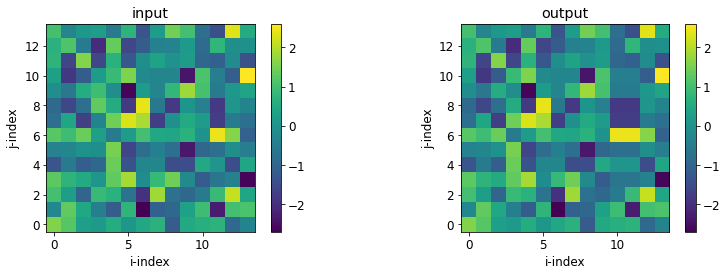

In [3]:
# REMOVE - Solution
nhalo = 3
nx, ny, nz = 8, 8, 1
backend = "gtx86"

origin = (nhalo, nhalo, 0)
domain = (nx, ny, nz)
shape = (nx + 2*nhalo, ny + 2*nhalo, nz)

@gtscript.stencil(backend=backend)
def shift_by_one(a: Field[np.float64]):
    with computation(PARALLEL), interval(...):
        a = a[1, 0, 0]
        
# create some storages
in_field = gt4py.storage.from_array(np.random.randn(shape[0], shape[1], shape[2]), backend, origin, shape, dtype=np.float64)
out_field = in_field.copy()

# run stencil
shift_by_one(a=out_field, origin=origin, domain=domain)

# visualize results
plot_two_ij_slices(in_field, out_field)

## Stencil Program

The previous notebook introduced the horizontal Laplacian as an example stencil. A Laplacian is sometimes used as a numerical filter, but has the downside of not being very scale selective. Because of this, some models choose to implement higher order filters (e.g. [Xue 2000, Monthly Weather Review](http://twister.ou.edu/papers/Xue2000Diffusion.pdf)).

\begin{eqnarray}
\frac{\partial \phi}{\partial t} = S + (-1)^{n/2+1} \alpha_n \nabla^n \phi \\
\end{eqnarray}

where $S$ represents all other processes, $n$ is the order of the filter, and $\alpha_n$ is the filter constant. Let's assume $S=0$ and take a closer look at the 2nd-order filter (n=2)

\begin{eqnarray}
\frac{\partial \phi}{\partial t} & = & + \alpha_2 \nabla^2 \phi \\
& = & + \alpha_2 \Delta \phi \\[2ex]
\end{eqnarray}

and the 4th-order filter (n=4)

\begin{eqnarray}
\frac{\partial \phi}{\partial t} & = & - \alpha_4 \nabla^4 \phi \\
& = & - \alpha_4 \Delta \left( \Delta \phi \right) \\
\end{eqnarray}

where $\alpha_2$ and $\alpha_4$ are the diffusion coefficients. This corresponds to a double application of a simple horizontal Laplacian where we choose the coefficient correspondingly. So we can potentially re-use the stencil we have already coded in the previous session, which is reproduced below for convenience, but using a different initialization of the input field.

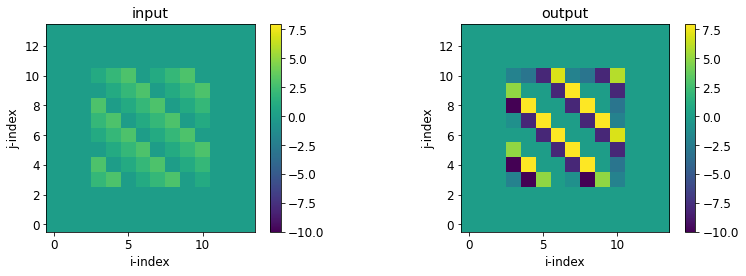

In [5]:
# setup
nhalo = 3
nx, ny, nz = 8, 8, 1
backend = "numpy"

# stencils
@gtscript.stencil(backend=backend)
def laplacian(in_field: Field[np.float64], out_field: Field[np.float64]):
    with computation(PARALLEL), interval(...):
        out_field = (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])
        
# define storages
origin = (nhalo, nhalo, 0)
shape = (nx + 2*nhalo, ny + 2*nhalo, nz)
in_field = gt4py.storage.zeros(backend, origin, shape, dtype=np.float64)
for k in range(nz):
    for j in range(nhalo, ny + nhalo):
        for i in range(nhalo, nx + nhalo):
            in_field[i, j, k] = (i + j + k) % 4        
out_field = gt4py.storage.zeros(backend, origin, shape, dtype=np.float64)

# apply stencil
laplacian(in_field=in_field, out_field=out_field, origin=(nhalo, nhalo, 0), domain=(nx, ny, nz))

# visualize results
plot_two_ij_slices(in_field, out_field)

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    We are going to extend the above program to a full stencil program applying multiple iterations of the 4th-order numerical diffusion filter to an input field using an Euler forward step.
    <ol>
        <li style="margin-bottom: 10px"> Implement a second stencil <code>euler_forward(in_field, out_field, alpha)</code> which computes the time update $\mathrm{out\_field} = \mathrm{in\_field} + \alpha \,\, \mathrm{out\_field}$.</li>
        <li style="margin-bottom: 10px"> Implement a timeloop which does 20 iterations of calling <code>laplacian(in_field, out_field)</code>, <code>euler_step(in_field, out_field, alpha)</code> and a finally does a timeswap using <code>in_field[:] = out_field[:]</code> at the end of each iteration.</li>
        <li style="margin-bottom: 10px"> Run the program and check your results by visually inspection. Note that if $\alpha_2 > 1/8$ you filter will be unstable.</li>
        <li style="margin-bottom: 10px"> Imlement a 4th-order filter by calling the <code>laplacian</code> stencil twice. It is easiest to create an additional storage <code>tmp_field</code> to carry the intermediate result from the first invocation to the second. Make sure you adapt the <code>origin</code> and <code>domain</code> for the first invocation of <code>laplacian</code> to compute on an extended domain. Also, don't forget to flip the sign in front of the diffusion coefficient in <code>euler_step</code>.</li>
        <li style="margin-bottom: 10px"> Run you program and check your results by visually inspection. Note that if $\alpha_4 > 1/32$ you filter will be unstable.</li>
    </ol>
</div>

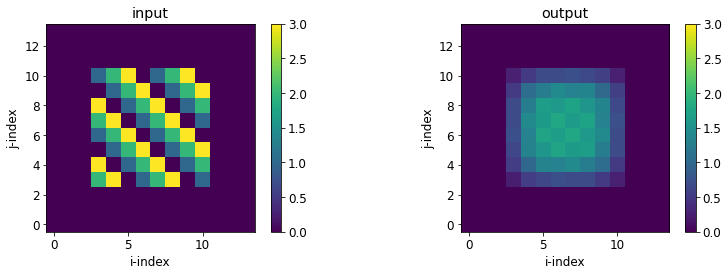

In [35]:
# REMOVE - Solution

# setup
nhalo = 3
nx, ny, nz = 8, 8, 1
backend = "numpy"

# stencils
@gtscript.stencil(backend=backend)
def laplacian(in_field: Field[np.float64], out_field: Field[np.float64]):
    with computation(PARALLEL), interval(...):
        out_field = (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])
        
@gtscript.stencil(backend=backend)
def euler_step(in_field: Field[np.float64], out_field: Field[np.float64], *, alpha: np.float64):
    with computation(PARALLEL), interval(...):
        out_field = in_field - alpha * out_field
        
# define storages
origin = (nhalo, nhalo, 0)
shape = (nx + 2*nhalo, ny + 2*nhalo, nz)
in_field = gt4py.storage.zeros(backend, origin, shape, dtype=np.float64)
for k in range(nz):
    for j in range(nhalo, ny + nhalo):
        for i in range(nhalo, nx + nhalo):
            in_field[i, j, k] = (i + j + k) % 4        
orig_field = in_field.copy()
out_field = gt4py.storage.zeros(backend, origin, shape, dtype=np.float64)
tmp_field = out_field.copy()

# apply stencil
alpha = 1./32.
for n in range(20):
    laplacian(in_field=in_field, out_field=tmp_field, origin=(nhalo-1, nhalo-1, 0), domain=(nx+2, ny+2, nz))
    laplacian(in_field=tmp_field, out_field=out_field, origin=(nhalo, nhalo, 0), domain=(nx, ny, nz))
    euler_step(in_field=in_field, out_field=out_field, alpha=alpha, origin=(nhalo, nhalo, 0), domain=(nx, ny, nz))
    in_field[:] = out_field[:]


# visualize results
plot_two_ij_slices(orig_field, out_field)

## Stages and Stage Extents

TODO: Write introduction to stages and stage extents here.<br>
- statement after statement, horizontal is fine
- "magic" extension to what is consumed

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    <ol>
        <li style="margin-bottom: 10px"> Copy the above program into a cell below. Replace the two stencils <code>laplacian</code> and <code>euler_step</code> with a single stencil <code>numerical_filter(in_field, tmp_field, out_field, alpha)</code> which implements the two laplacians as well as the Euler forward integration as individual stages.</li>
        <li style="margin-bottom: 10px"> Check your results against the reference above.</li>
    </ol>
</div>

TODO: find out why result below does not match result above!!!

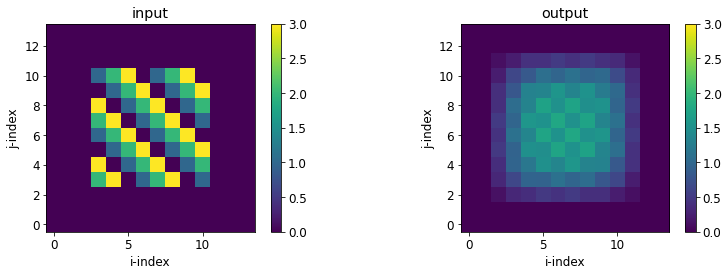

In [11]:
# REMOVE - Solution

# setup
nhalo = 3
nx, ny, nz = 8, 8, 1
backend = "numpy"

# stencils
@gtscript.stencil(backend=backend)
def numerical_filter(in_field: Field[np.float64], tmp_field: Field[np.float64], out_field: Field[np.float64], *, alpha: np.float64):
    with computation(PARALLEL), interval(...):
        tmp_field = (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])
        out_field = (-4. * tmp_field +
            tmp_field[1, 0, 0] + tmp_field[-1, 0, 0] + 
            tmp_field[0, 1, 0] + tmp_field[0, -1, 0])
        out_field = in_field - alpha * out_field
        
# define storages
origin = (nhalo, nhalo, 0)
shape = (nx + 2*nhalo, ny + 2*nhalo, nz)
in_field = gt4py.storage.zeros(backend, origin, shape, dtype=np.float64)
for k in range(nz):
    for j in range(nhalo, ny + nhalo):
        for i in range(nhalo, nx + nhalo):
            in_field[i, j, k] = (i + j + k) % 4        
orig_field = in_field.copy()
out_field = gt4py.storage.zeros(backend, origin, shape, dtype=np.float64)
tmp_field = out_field.copy()

# apply stencil
alpha = 1./32.
for n in range(20):
    numerical_filter(in_field=in_field, tmp_field=tmp_field, out_field=out_field, alpha=alpha, origin=(nhalo-1, nhalo-1, 0), domain=(nx+2, ny+2, nz))
    in_field[:] = out_field[:]

# visualize results
plot_two_ij_slices(orig_field, out_field)

## Temporaries

TODO: Write introduction to temporaries here.<br>
- They can be fields, they can be local variables
- use as see fit

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    <ol>
        <li style="margin-bottom: 10px"> Replace the storage <code>tmp_field</code> with a temporary of the same name. Concretely, remove <code>tmp_field</code> from the argument list of the <code>numerical_filter</code> stencil and remove the code which allocated a storage for <code>tmp_field</code>.</li>
        <li style="margin-bottom: 10px"> Check your results against the reference above.</li>
    </ol>
</div>

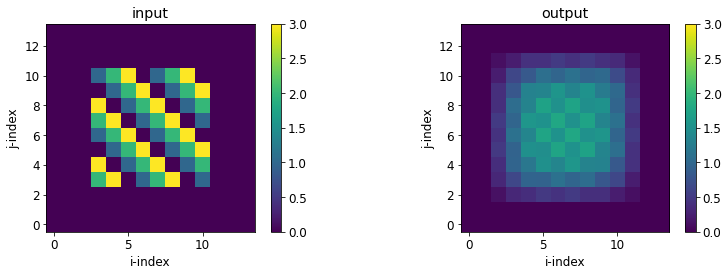

In [12]:
# REMOVE - Solution

# setup
nhalo = 3
nx, ny, nz = 8, 8, 1
backend = "numpy"

# stencils
@gtscript.stencil(backend=backend)
def numerical_filter(in_field: Field[np.float64], out_field: Field[np.float64], *, alpha: np.float64):
    with computation(PARALLEL), interval(...):
        tmp_field = (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])
        out_field = (-4. * tmp_field +
            tmp_field[1, 0, 0] + tmp_field[-1, 0, 0] + 
            tmp_field[0, 1, 0] + tmp_field[0, -1, 0])
        out_field = in_field - alpha * out_field
        
# define storages
origin = (nhalo, nhalo, 0)
shape = (nx + 2*nhalo, ny + 2*nhalo, nz)
in_field = gt4py.storage.zeros(backend, origin, shape, dtype=np.float64)
for k in range(nz):
    for j in range(nhalo, ny + nhalo):
        for i in range(nhalo, nx + nhalo):
            in_field[i, j, k] = (i + j + k) % 4        
orig_field = in_field.copy()
out_field = gt4py.storage.zeros(backend, origin, shape, dtype=np.float64)

# apply stencil
alpha = 1./32.
for n in range(20):
    numerical_filter(in_field=in_field, out_field=out_field, alpha=alpha, origin=(nhalo-1, nhalo-1, 0), domain=(nx+2, ny+2, nz))
    in_field[:] = out_field[:]

# visualize results
plot_two_ij_slices(orig_field, out_field)

## Intro to backends

TODO: adapt the code below to the code above. <br>
TODO: discuss with Oli & Eddie to coordinate content before working more on this section. <br>

why

In [9]:
import timeit

iterations = np.arange(1,6)

In [10]:
@gtscript.stencil(backend="numpy")
def diffusion_stencil(in_storage: gtscript.Field[float], out_storage: gtscript.Field[float]):
    with computation(PARALLEL), interval(...):
        alpha = 1.0 / 32.0
        tmp_storage = (
            -4.0 * in_storage[0, 0, 0]
            + in_storage[1, 0, 0]
            + in_storage[-1, 0, 0]
            + in_storage[0, 1, 0]
            + in_storage[0, -1, 0]
        )
        out_storage = (
            -4.0 * tmp_storage[0, 0, 0]
            + tmp_storage[1, 0, 0]
            + tmp_storage[-1, 0, 0]
            + tmp_storage[0, 1, 0]
            + tmp_storage[0, -1, 0]
        )
        out_storage = in_storage[0, 0, 0] - alpha * out_storage[0, 0, 0]
        in_storage = out_storage


In [11]:
def run_numpy_experiment(size):
    nx = 100*size
    halo = 3
    shape = (nx + 2 * halo, nx + 2 * halo, 1)
    in_storage = gt4py.storage.zeros(
        shape=shape,
        default_origin=(0, 0, 0),
        dtype=float,
        backend="numpy",
    )
    in_storage.data[halo + nx // 3 : halo + 2 * nx // 3, halo + nx // 3 : halo + 2 * nx // 3, :] = 1
    out_storage = gt4py.storage.zeros(
        shape=shape,
        default_origin=(0, 0, 0),
        dtype=float,
        backend="numpy",
    )

    tic = timeit.default_timer()
    for i in range(500):
        diffusion_stencil(in_storage, out_storage, origin=(halo, halo, 0), domain=(nx, nx, 1))
    toc = timeit.default_timer()
    return toc - tic
    

collect numpy numbers

In [12]:
numpy_values = np.zeros(5)

for j in range(5):
    numpy_values[j] = run_numpy_experiment(iterations[j])



same for gtx86

In [13]:
@gtscript.stencil(backend="gtx86")
def diffusion_stencil_x86(in_storage: gtscript.Field[float], out_storage: gtscript.Field[float]):
    with computation(PARALLEL), interval(...):
        alpha = 1.0 / 32.0
        tmp_storage = (
            -4.0 * in_storage[0, 0, 0]
            + in_storage[1, 0, 0]
            + in_storage[-1, 0, 0]
            + in_storage[0, 1, 0]
            + in_storage[0, -1, 0]
        )
        out_storage = (
            -4.0 * tmp_storage[0, 0, 0]
            + tmp_storage[1, 0, 0]
            + tmp_storage[-1, 0, 0]
            + tmp_storage[0, 1, 0]
            + tmp_storage[0, -1, 0]
        )
        out_storage = in_storage[0, 0, 0] - alpha * out_storage[0, 0, 0]
        in_storage = out_storage

In [14]:
def run_gtx86_experiment(size):
    gtx86_values = np.zeros(5)
    nx = 100
    halo = 3
    shape = (nx + 2 * halo, nx + 2 * halo, 1)
    in_storage_x86 = gt4py.storage.zeros(
        shape=shape,
        default_origin=(0, 0, 0),
        dtype=float,
        backend="gtx86",
    )
    in_storage_x86.data[halo + nx // 3 : halo + 2 * nx // 3, halo + nx // 3 : halo + 2 * nx // 3, :] = 1
    out_storage_x86 = gt4py.storage.zeros(
        shape=shape,
        default_origin=(0, 0, 0),
        dtype=float,
        backend="gtx86",
    )
    tic = timeit.default_timer()
    for i in range(500):
        diffusion_stencil_x86(in_storage_x86, out_storage_x86, origin=(halo, halo, 0), domain=(nx, nx, 1))
    toc = timeit.default_timer()
    return toc - tic

In [15]:
gtx86_values = np.zeros(5)
for j in range(5):
    gtx86_values[j] = run_gtx86_experiment(iterations[j])

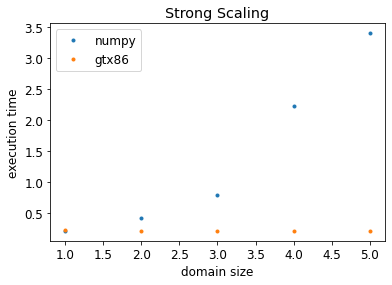

In [16]:
plt.plot(iterations, numpy_values, ".", label="numpy")
plt.plot(iterations, gtx86_values, ".", label="gtx86")


plt.title("Strong Scaling")
plt.legend()
plt.xlabel("domain size")
plt.ylabel("execution time")

plt.show()